# Time Series Forecasting with FLAML Library

## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can

 - serve as an economical AutoML engine,
 - be used as a fast hyperparameter tuning tool, or
 - be embedded in self-tuning software that requires low latency & resource in repetitive tuning tasks.

In this notebook, we demonstrate how to use FLAML library for time series forecasting tasks: univariate time series forecasting (only time), multivariate time series forecasting (with exogneous variables) and forecasting discrete values.

FLAML requires Python>=3.7. To run this notebook example, please install flaml with the notebook and forecast option:


In [ ]:
%pip install flaml[notebook,ts_forecast]
# avoid version 1.0.2 to 1.0.5 for this notebook due to a bug for arima and sarimax's init config

## 2. Forecast Problem

### Load data and preprocess

Import co2 data from statsmodel. The dataset is from “Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.,” which collected CO2 samples from March 1958 to December 2001. The task is to predict monthly CO2 samples given only timestamps.

In [2]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas().data
# data is given in weeks, but the task is to predict monthly, so use monthly averages instead
data = data['co2'].resample('MS').mean()
data = data.bfill().ffill()  # makes sure there are no missing values
data = data.to_frame().reset_index()

In [3]:
# split the data into a train dataframe and X_test and y_test dataframes, where the number of samples for test is equal to
# the number of periods the user wants to predict
num_samples = data.shape[0]
time_horizon = 12
split_idx = num_samples - time_horizon
train_df = data[:split_idx]  # train_df is a dataframe with two columns: timestamp and label
X_test = data[split_idx:]['index'].to_frame()  # X_test is a dataframe with dates for prediction
y_test = data[split_idx:]['co2']  # y_test is a series of the values corresponding to the dates for prediction

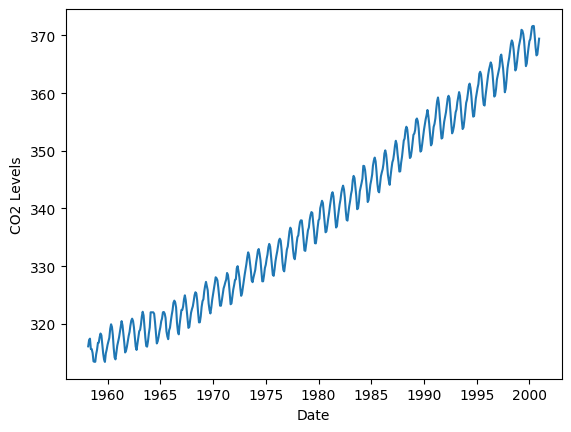

In [4]:
train_df

import matplotlib.pyplot as plt

plt.plot(train_df['index'], train_df['co2'])
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.show()

### Run FLAML
The AutoML class provides a scikit-learn style estimator (with standard fit and predict functions) for AutoML. In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them.

The documentation of AutoML class can be found here: [Documentation of AutoML](https://microsoft.github.io/FLAML/docs/reference/automl/#automl-objects)

In [5]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

The AutoML class constructor takes a list of user-specified setting for fitting and prediction. A comprehensive list of setting options available can be found here [List of setting options](https://microsoft.github.io/FLAML/docs/reference/automl/#automl-objects). In particular, users may want to specify a metric for optimization. A list of built-in optimization metrics available (as well as how to customize metrics) can be found at [here](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML/#optimization-metric).

In [6]:
settings = {
    "time_budget": 240,  # total running time in seconds
    "metric": 'mape',  # primary metric for validation: 'mape' is generally used for forecast tasks
    "task": 'ts_forecast',  # task type
    "log_file_name": 'CO2_forecast.log',  # flaml log file
    "eval_method": "holdout",  # validation method can be chosen from ['auto', 'holdout', 'cv']
    "seed": 7654321,  # random seed
}

In [ ]:
'''The main flaml automl API'''
automl.fit(dataframe=train_df,  # training data
           label='co2',  # label column
           period=time_horizon,  # key word argument 'period' must be included for forecast task)
           **settings)

### Best model and metric

In [ ]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print(f'Best mape on validation data: {automl.best_loss}')
print(f'Training duration of best run: {automl.best_config_train_time}s')

Best ML leaner: sarimax
Best hyperparmeter config: {'p': 8, 'd': 0, 'q': 8, 'P': 6, 'D': 3, 'Q': 1, 's': 6}
Best mape on validation data: 0.00043466573064228554
Training duration of best run: 0.7340686321258545s


In [ ]:
automl.model.estimator

In [ ]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
''' compute predictions of testing dataset '''
flaml_y_pred = automl.predict(X_test)
print(f"Predicted labels\n{flaml_y_pred}")
print(f"True labels\n{y_test}")

Predicted labels
2001-01-01    370.568362
2001-02-01    371.297747
2001-03-01    372.087653
2001-04-01    373.040897
2001-05-01    373.638221
2001-06-01    373.202665
2001-07-01    371.621574
2001-08-01    369.611740
2001-09-01    368.307775
2001-10-01    368.360786
2001-11-01    369.476460
2001-12-01    370.849193
Freq: MS, Name: predicted_mean, dtype: float64
True labels
514    370.175
515    371.325
516    372.060
517    372.775
518    373.800
519    373.060
520    371.300
521    369.425
522    367.880
523    368.050
524    369.375
525    371.020
Name: co2, dtype: float64


In [ ]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('mape', '=', sklearn_metric_loss_score('mape', y_true=y_test, y_predict=flaml_y_pred))

mape = 0.0005710586398294955


### Log history

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=180)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 502, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'optimize_for_horizon': False, 'lags': 3}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'optimize_for_horizon': False, 'lags': 3}}
{'Current Learner': 'lgbm', 'Current Sample': 502, 'Current Hyper-parameters': {'n_estimators': 8, 'num_leaves': 4, 'min_child_samples': 19, 'learning_rate': 0.18686130359903158, 'log_max_bin': 9, 'colsample_bytree': 0.9311834484407709, 'reg_alpha': 0.0013872402855481538, 'reg_lambda': 0.43503398494225104, 'optimize_for_horizon': False, 'lags': 1}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_esti

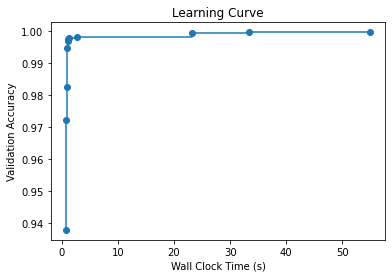

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### Visualize

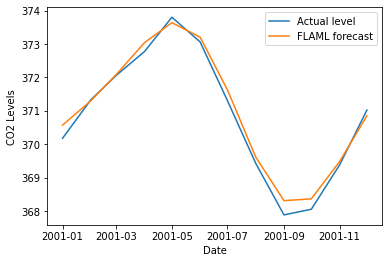

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_test, y_test, label='Actual level')
plt.plot(X_test, flaml_y_pred, label='FLAML forecast')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()

## 3. Forecast Problems with Exogenous Variables

### Load Data and Preprocess

Load dataset on NYC energy consumption. The task is to predict the average hourly demand of enegry used in a day given information on time, temperature, and precipitation. Temperature and precipiation values are both continuous values. To demonstrate FLAML's ability to handle categorical values as well, create a column with categorical values, where 1 denotes daily tempurature is above monthly average and 0 is below.

In [1]:
''' multivariate time series forecasting dataset'''
import pandas as pd
# pd.set_option("display.max_rows", None, "display.max_columns", None)
multi_df = pd.read_csv(
    "https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv"
)
# preprocessing data
multi_df["timeStamp"] = pd.to_datetime(multi_df["timeStamp"])
multi_df = multi_df.set_index("timeStamp")
multi_df = multi_df.resample("D").mean()
multi_df["temp"] = multi_df["temp"].fillna(method="ffill")
multi_df["precip"] = multi_df["precip"].fillna(method="ffill")
multi_df = multi_df[:-2]  # last two rows are NaN for 'demand' column so remove them
multi_df = multi_df.reset_index()

In [2]:
''' Use feature engineering to create a categorical value'''
# Using temperature values create categorical values 
# where 1 denotes daily tempurature is above monthly average and 0 is below.

def get_monthly_avg(data):
    data["month"] = data["timeStamp"].dt.month
    data = data[["month", "temp"]].groupby("month")
    data = data.agg({"temp": "mean"})
    return data

monthly_avg = get_monthly_avg(multi_df).to_dict().get("temp")

def above_monthly_avg(date, temp):
    month = date.month
    if temp > monthly_avg.get(month):
        return 1
    else:
        return 0

multi_df["temp_above_monthly_avg"] = multi_df.apply(
    lambda x: above_monthly_avg(x["timeStamp"], x["temp"]), axis=1
)

del multi_df["month"]  # remove temperature column to reduce redundancy

In [3]:
# split data into train and test
num_samples = multi_df.shape[0]
multi_time_horizon = 180
split_idx = num_samples - multi_time_horizon
multi_train_df = multi_df[:split_idx]
multi_test_df = multi_df[split_idx:]

multi_X_test = multi_test_df[
    ["timeStamp", "precip", "temp", "temp_above_monthly_avg"]
]  # test dataframe must contain values for the regressors / multivariate variables
multi_y_test = multi_test_df["demand"]

multi_train_df

,timeStamp,demand,precip,temp,temp_above_monthly_avg
0,2012-01-01,4954.833333,0.002487,46.510000,1
1,2012-01-02,5302.954167,0.000000,40.496667,1
2,2012-01-03,6095.512500,0.000000,26.672500,0
3,2012-01-04,6336.266667,0.000000,20.585000,0
4,2012-01-05,6130.245833,0.000000,33.577500,1
...,...,...,...,...,...
1864,2017-02-07,5861.319833,0.011938,39.020417,1
1865,2017-02-08,5667.644708,0.001258,47.305417,1
1866,2017-02-09,5947.661958,0.027029,29.242500,0
1867,2017-02-10,6195.122500,0.000179,25.048750,0


### Run FLAML

In [5]:
from flaml import AutoML
automl = AutoML()
settings = {
    "time_budget": 10,  # total running time in seconds
    "metric": "mape",  # primary metric
    "task": "ts_forecast",  # task type
    "log_file_name": "energy_forecast_categorical.log",  # flaml log file
    "eval_method": "holdout",
    "log_type": "all",
    "label": "demand",
}
'''The main flaml automl API'''
try:
    import prophet

    automl.fit(dataframe=multi_train_df, **settings, period=multi_time_horizon)
except ImportError:
    print("not using prophet due to ImportError")
    automl.fit(
        dataframe=multi_train_df,
        **settings,
        estimator_list=["arima", "sarimax"],
        period=multi_time_horizon,
    )

[flaml.automl: 08-13 00:54:48] {2540} INFO - task = ts_forecast
[flaml.automl: 08-13 00:54:48] {2542} INFO - Data split method: time
[flaml.automl: 08-13 00:54:48] {2545} INFO - Evaluation method: holdout
[flaml.automl: 08-13 00:54:48] {2664} INFO - Minimizing error metric: mape
[flaml.automl: 08-13 00:54:48] {2806} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'prophet', 'arima', 'sarimax']
[flaml.automl: 08-13 00:54:48] {3108} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-13 00:54:50] {3241} INFO - Estimated sufficient time budget=13549s. Estimated necessary time budget=14s.
[flaml.automl: 08-13 00:54:50] {3288} INFO -  at 1.7s,	estimator lgbm's best error=0.0854,	best estimator lgbm's best error=0.0854
[flaml.automl: 08-13 00:54:50] {3108} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-13 00:54:50] {3288} INFO -  at 1.7s,	estimator lgbm's best error=0.0854,	best estimator lgbm's best error=0.0854
[flaml.a

### Prediction and Metrics

In [6]:
''' compute predictions of testing dataset '''
multi_y_pred = automl.predict(multi_X_test)
print("Predicted labels", multi_y_pred)
print("True labels", multi_y_test)

Predicted labels [5816.55214206 5905.70575447 5834.65947255 5859.27980938 5981.48416072
 5882.10376347 5551.01099266 5435.01475996 5471.23496654 5569.51972162
 5540.85105607 5396.28260123 5462.80727224 5434.07936867 5511.56573622
 5574.25340904 5447.35826516 5555.70270542 5657.09729925 5949.68245693
 5968.01898401 5791.25872055 5712.91089711 5662.27425465 5638.28515788
 5630.24299004 5910.41105978 6305.40454128 5936.47176065 6052.48858565
 6249.11522565 6472.15770449 6203.12944304 5678.46456796 5514.886543
 5479.08912968 5521.10433109 5527.11532443 5813.63023796 6112.91322944
 5661.36696892 5146.82879591 5332.76868247 5649.76768828 5741.38048438
 5412.30150321 5421.63190406 5648.53641688 5106.03841483 4982.47727835
 5403.54145745 5665.41675811 5333.27032542 5619.01917593 5406.80836839
 5103.61165688 4886.87942122 5323.86713609 5539.9843075  5518.89510834
 5327.27090772 5287.19840493 4934.96448807 5471.16766936 6062.58941089
 5431.09529611 5470.89238927 5362.88508552 5380.14421299 5071.

In [7]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('mape', '=', sklearn_metric_loss_score('mape', y_true=multi_y_test, y_predict=multi_y_pred))

mape = 0.04171642942259451


### Visualize

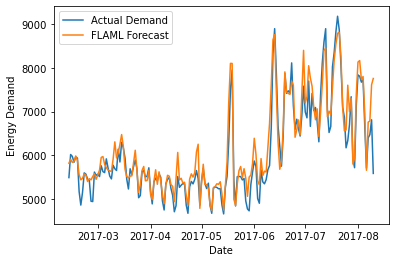

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(multi_X_test["timeStamp"], multi_y_test, label="Actual Demand")
plt.plot(multi_X_test["timeStamp"], multi_y_pred, label="FLAML Forecast")
plt.xlabel("Date")
plt.ylabel("Energy Demand")
plt.legend()
plt.show()

## 4. Forecasting Discrete Values

### Load Dataset and Preprocess

Import [sales data](https://hcrystalball.readthedocs.io/en/v0.1.7/api/hcrystalball.utils.get_sales_data.html) from hcrystalball. The task is to predict whether daily sales will be above mean sales for thirty days into the future.

In [2]:
from hcrystalball.utils import get_sales_data
time_horizon = 30
df = get_sales_data(n_dates=180, n_assortments=1, n_states=1, n_stores=1)
df = df[["Sales", "Open", "Promo", "Promo2"]]
# feature engineering - create a discrete value column
# 1 denotes above mean and 0 denotes below mean
import numpy as np
df["above_mean_sales"] = np.where(df["Sales"] > df["Sales"].mean(), 1, 0)
df.reset_index(inplace=True)
# train-test split
discrete_train_df = df[:-time_horizon]
discrete_test_df = df[-time_horizon:]
discrete_X_train, discrete_X_test = (
    discrete_train_df[["Date", "Open", "Promo", "Promo2"]],
    discrete_test_df[["Date", "Open", "Promo", "Promo2"]],
)
discrete_y_train, discrete_y_test = discrete_train_df["above_mean_sales"], discrete_test_df["above_mean_sales"]

In [3]:
discrete_train_df

,Date,Sales,Open,Promo,Promo2,above_mean_sales
0,2015-02-02,24894,True,True,False,1
1,2015-02-03,22139,True,True,False,1
2,2015-02-04,20452,True,True,False,1
3,2015-02-05,20977,True,True,False,1
4,2015-02-06,19151,True,True,False,1
...,...,...,...,...,...,...
145,2015-06-27,13108,True,False,False,0
146,2015-06-28,0,False,False,False,0
147,2015-06-29,28456,True,True,False,1
148,2015-06-30,27140,True,True,False,1


### Run FLAML

In [4]:
from flaml import AutoML
automl = AutoML()

In [6]:
settings = {
    "time_budget": 15,  # total running time in seconds
    "metric": "accuracy",  # primary metric
    "task": "ts_forecast_classification",  # task type
    "log_file_name": "sales_classification_forecast.log",  # flaml log file
    "eval_method": "holdout",
}

In [7]:
"""The main flaml automl API"""
automl.fit(X_train=discrete_X_train,
           y_train=discrete_y_train,
           **settings,
           period=time_horizon)

[flaml.automl: 08-03 20:33:26] {2520} INFO - task = ts_forecast_classification
[flaml.automl: 08-03 20:33:26] {2522} INFO - Data split method: time
[flaml.automl: 08-03 20:33:26] {2525} INFO - Evaluation method: holdout
[flaml.automl: 08-03 20:33:26] {2644} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 08-03 20:33:27] {2786} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 08-03 20:33:27] {3088} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-03 20:33:29] {3221} INFO - Estimated sufficient time budget=11912s. Estimated necessary time budget=12s.
[flaml.automl: 08-03 20:33:29] {3268} INFO -  at 2.2s,	estimator lgbm's best error=0.2667,	best estimator lgbm's best error=0.2667
[flaml.automl: 08-03 20:33:29] {3088} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-03 20:33:29] {3268} INFO -  at 2.2s,	estimator lgbm's best error=0.2667,	best estimator lgbm's best error=0.2667
[flaml.automl: 08-

### Best Model and Metric

In [8]:
""" retrieve best config and best learner"""
print("Best ML leaner:", automl.best_estimator)
print("Best hyperparmeter config:", automl.best_config)
print(f"Best mape on validation data: {automl.best_loss}")
print(f"Training duration of best run: {automl.best_config_train_time}s")
print(automl.model.estimator)

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 4, 'num_leaves': 5, 'min_child_samples': 8, 'learning_rate': 0.7333523408279569, 'log_max_bin': 5, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 7.593190995489472, 'optimize_for_horizon': False, 'lags': 5}
Best mape on validation data: 0.033333333333333326
Training duration of best run: 0.017951011657714844s
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.7333523408279569,
               max_bin=31, max_depth=-1, min_child_samples=8,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=4,
               n_jobs=-1, num_leaves=5, objective=None, random_state=None,
               reg_alpha=0.0009765625, reg_lambda=7.593190995489472,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbose=-1)


In [9]:
""" compute predictions of testing dataset """
discrete_y_pred = automl.predict(discrete_X_test)
print("Predicted label", discrete_y_pred)
print("True label", discrete_y_test)

Predicted label [1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1]
True label 150    1
151    1
152    0
153    0
154    1
155    1
156    1
157    1
158    1
159    0
160    0
161    1
162    1
163    1
164    1
165    1
166    0
167    0
168    1
169    1
170    1
171    1
172    1
173    0
174    0
175    1
176    1
177    1
178    1
179    1
Name: above_mean_sales, dtype: int32


In [10]:
from flaml.ml import sklearn_metric_loss_score
print("accuracy", "=", 1 - sklearn_metric_loss_score("accuracy", discrete_y_test, discrete_y_pred))

accuracy = 1.0


## 5. Forecast Problems with Panel Datasets (Multiple Time Series)

### Load data and preprocess

Import Stallion & Co.'s beverage sales data from pytorch-forecasting, orginally from Kaggle. The dataset contains about 21,000 monthly historic sales record as well as additional information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry. There are thousands of unique wholesaler-SKU/products combinations, each representing an individual time series. The task is to provide a six month forecast of demand at SKU level for each wholesaler.

In [1]:
def get_stalliion_data():
    from pytorch_forecasting.data.examples import get_stallion_data

    data = get_stallion_data()
    # add time index
    data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
    data["time_idx"] -= data["time_idx"].min()
    # add additional features
    data["month"] = data.date.dt.month.astype(str).astype(
        "category"
    )  # categories have be strings
    data["log_volume"] = np.log(data.volume + 1e-8)
    data["avg_volume_by_sku"] = data.groupby(
        ["time_idx", "sku"], observed=True
    ).volume.transform("mean")
    data["avg_volume_by_agency"] = data.groupby(
        ["time_idx", "agency"], observed=True
    ).volume.transform("mean")
    # we want to encode special days as one variable and thus need to first reverse one-hot encoding
    special_days = [
        "easter_day",
        "good_friday",
        "new_year",
        "christmas",
        "labor_day",
        "independence_day",
        "revolution_day_memorial",
        "regional_games",
        "beer_capital",
        "music_fest",
    ]
    data[special_days] = (
        data[special_days]
        .apply(lambda x: x.map({0: "-", 1: x.name}))
        .astype("category")
    )
    return data, special_days

In [3]:
import numpy as np
data, special_days = get_stalliion_data()
time_horizon = 6  # predict six months
# make time steps first column
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()
training_cutoff = data["time_idx"].max() - time_horizon
ts_col = data.pop("date")
data.insert(0, "date", ts_col)
# FLAML assumes input is not sorted, but we sort here for comparison purposes with y_test
data = data.sort_values(["agency", "sku", "date"])
X_train = data[lambda x: x.time_idx <= training_cutoff]
X_test = data[lambda x: x.time_idx > training_cutoff]
y_train = X_train.pop("volume")
y_test = X_test.pop("volume")

In [4]:
X_train

,date,agency,sku,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
25,2013-01-01,Agency_01,SKU_01,492612703,718394219,17.072000,1141.500000,1033.432731,108.067269,153733,...,0,-,-,9.467128,249,0,1,4.390441,2613.377501,74.829600
7183,2013-02-01,Agency_01,SKU_01,431937346,753938444,19.984000,1141.500000,1065.417195,76.082805,153733,...,0,-,-,6.665160,249,1,2,4.585620,2916.978087,90.036700
8928,2013-03-01,Agency_01,SKU_01,509281531,892192092,24.600000,1179.345820,1101.133633,78.212187,153733,...,0,-,music_fest,6.631828,249,2,3,4.895628,3215.061952,130.487150
10588,2013-04-01,Agency_01,SKU_01,532390389,838099501,27.532000,1226.687500,1138.283357,88.404143,153733,...,0,-,-,7.206737,249,3,4,4.992553,3515.822697,130.246150
12260,2013-05-01,Agency_01,SKU_01,551755254,864420003,29.396000,1230.331104,1148.969634,81.361470,153733,...,0,-,-,6.612974,249,4,5,5.168254,3688.107793,159.051550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8403,2017-02-01,Agency_60,SKU_23,530252010,850913048,25.242657,4261.294565,4087.082609,174.211956,2180611,...,0,-,-,4.088240,190,49,2,0.924259,2.418750,2664.670179
10359,2017-03-01,Agency_60,SKU_23,613143990,886129111,25.374816,4259.769000,4126.776000,132.993000,2180611,...,0,-,music_fest,3.122071,190,50,3,0.536493,4.353750,2965.472829
12114,2017-04-01,Agency_60,SKU_23,589969396,940912941,27.109204,4261.896428,4115.753572,146.142856,2180611,...,0,-,-,3.429057,190,51,4,0.231112,2.396250,2861.802300
13884,2017-05-01,Agency_60,SKU_23,628759461,917412482,28.479272,0.000000,0.000000,0.000000,2180611,...,0,-,-,0.000000,190,52,5,-18.420681,2.182500,3489.190286


### Run FLAML

In [5]:
from flaml import AutoML
automl = AutoML()
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": "mape",  # primary metric
    "task": "ts_forecast_panel",  # task type
    "log_file_name": "stallion_forecast.log",  # flaml log file
    "eval_method": "holdout",
}
fit_kwargs_by_estimator = {
    "tft": {
        "max_encoder_length": 24,
        "static_categoricals": ["agency", "sku"],
        "static_reals": ["avg_population_2017", "avg_yearly_household_income_2017"],
        "time_varying_known_categoricals": ["special_days", "month"],
        "variable_groups": {
            "special_days": special_days
        },  # group of categorical variables can be treated as one variable
        "time_varying_known_reals": [
            "time_idx",
            "price_regular",
            "discount_in_percent",
        ],
        "time_varying_unknown_categoricals": [],
        "time_varying_unknown_reals": [
            "y",  # always need a 'y' column for the target column
            "log_volume",
            "industry_volume",
            "soda_volume",
            "avg_max_temp",
            "avg_volume_by_agency",
            "avg_volume_by_sku",
        ],
        "batch_size": 128,
        "gpu_per_trial": -1,
    }
}
"""The main flaml automl API"""
automl.fit(
    X_train=X_train,
    y_train=y_train,
    **settings,
    period=time_horizon,
    group_ids=["agency", "sku"],
    fit_kwargs_by_estimator=fit_kwargs_by_estimator,
)

Missing timestamps detected. To avoid error with estimators, set estimator list to ['prophet']. 
[flaml.automl: 08-13 01:07:10] {2540} INFO - task = ts_forecast_panel
[flaml.automl: 08-13 01:07:10] {2542} INFO - Data split method: time
[flaml.automl: 08-13 01:07:10] {2545} INFO - Evaluation method: holdout
[flaml.automl: 08-13 01:07:10] {2664} INFO - Minimizing error metric: mape
[flaml.automl: 08-13 01:07:10] {2806} INFO - List of ML learners in AutoML Run: ['tft']
[flaml.automl: 08-13 01:07:10] {3108} INFO - iteration 0, current learner tft
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2

Epoch 19: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, loss=49.6, v_num=0, train_loss_step=44.50, val_loss=62.50, train_loss_epoch=48.40]


[flaml.automl: 08-13 01:28:51] {3241} INFO - Estimated sufficient time budget=13011770s. Estimated necessary time budget=13012s.
[flaml.automl: 08-13 01:28:51] {3288} INFO -  at 1301.4s,	estimator tft's best error=1513915657450885.2500,	best estimator tft's best error=1513915657450885.2500
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encod

Epoch 19: 100%|██████████| 145/145 [01:13<00:00,  1.98it/s, loss=48.3, v_num=1, train_loss_step=52.00, val_loss=71.40, train_loss_epoch=47.80]


[flaml.automl: 08-13 01:53:06] {3552} INFO - retrain tft for 1454.1s
[flaml.automl: 08-13 01:53:06] {3559} INFO - retrained model: TemporalFusionTransformer(
  (loss): QuantileLoss()
  (logging_metrics): ModuleList(
    (0): SMAPE()
    (1): MAE()
    (2): RMSE()
    (3): MAPE()
  )
  (input_embeddings): MultiEmbedding(
    (embeddings): ModuleDict(
      (agency): Embedding(58, 16)
      (sku): Embedding(25, 10)
      (special_days): TimeDistributedEmbeddingBag(11, 6, mode=sum)
      (month): Embedding(12, 6)
    )
  )
  (prescalers): ModuleDict(
    (avg_population_2017): Linear(in_features=1, out_features=8, bias=True)
    (avg_yearly_household_income_2017): Linear(in_features=1, out_features=8, bias=True)
    (encoder_length): Linear(in_features=1, out_features=8, bias=True)
    (y_center): Linear(in_features=1, out_features=8, bias=True)
    (y_scale): Linear(in_features=1, out_features=8, bias=True)
    (time_idx): Linear(in_features=1, out_features=8, bias=True)
    (price_regul

### Prediction and Metrics

In [8]:
""" compute predictions of testing dataset """
y_pred = automl.predict(X_test)
print(y_test)
print(y_pred)

17156    59.292
18946    66.420
20680    95.904
3189     52.812
4954     37.908
          ...  
19207     1.980
20996     1.260
3499      0.990
5248      0.090
6793      2.250
Name: volume, Length: 2100, dtype: float64
Agency_01  SKU_01  2017-07-01    61.183556
                   2017-08-01    58.315655
                   2017-09-01    68.994713
                   2017-10-01    55.561470
                   2017-11-01    63.187683
                                   ...    
Agency_60  SKU_23  2017-08-01     3.096925
                   2017-09-01     2.331218
                   2017-10-01     1.883857
                   2017-11-01     3.282242
                   2017-12-01     3.580535
Length: 2100, dtype: float32


In [9]:
""" compute different metric values on testing dataset"""
from flaml.ml import sklearn_metric_loss_score
print("mape", "=", sklearn_metric_loss_score("mape", y_pred, y_test))

def smape(y_pred, y_test):
    import numpy as np

    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return round(
        np.mean(
            np.abs(y_pred - y_test) /
            ((np.abs(y_pred) + np.abs(y_test)) / 2)
        ) * 100, 2
    )

print("smape", "=", smape(y_pred, y_test))

mape = 2670450710119213.0
smape = 52.3


## 6. Comparison with Alternatives (CO2 Dataset)

FLAML's MAPE

In [33]:
from flaml.ml import sklearn_metric_loss_score
print('flaml mape', '=', sklearn_metric_loss_score('mape', flaml_y_pred, y_test))

flaml mape = 0.0005710586398294955


### Default Prophet

In [34]:
from prophet import Prophet
prophet_model = Prophet()

In [35]:
X_train_prophet = train_df.copy()
X_train_prophet = X_train_prophet.rename(columns={'index': 'ds', 'co2': 'y'})
prophet_model.fit(X_train_prophet)

In [36]:
X_test_prophet = X_test.copy()
X_test_prophet = X_test_prophet.rename(columns={'index': 'ds'})
prophet_y_pred = prophet_model.predict(X_test_prophet)['yhat']
print('Predicted labels', prophet_y_pred)
print('True labels', y_test)

Predicted labels 0     370.450675
1     371.177764
2     372.229577
3     373.419835
4     373.914917
5     373.406484
6     372.053428
7     370.149037
8     368.566631
9     368.646853
10    369.863891
11    371.135959
Name: yhat, dtype: float64
True labels 514    370.175
515    371.325
516    372.060
517    372.775
518    373.800
519    373.060
520    371.300
521    369.425
522    367.880
523    368.050
524    369.375
525    371.020
Name: co2, dtype: float64


Default Prophet MAPE

In [37]:
from flaml.ml import sklearn_metric_loss_score
print('default prophet mape', '=', sklearn_metric_loss_score('mape', prophet_y_pred, y_test))

default prophet mape = 0.0011396920680673015


### Auto ARIMA Models

In [38]:
from pmdarima.arima import auto_arima
import pandas as pd
import time

X_train_arima = train_df.copy()
X_train_arima.index = pd.to_datetime(X_train_arima['index'])
X_train_arima = X_train_arima.drop('index', axis=1)
X_train_arima = X_train_arima.rename(columns={'co2': 'y'})

In [39]:
# use same search space as FLAML
start_time = time.time()
arima_model = auto_arima(X_train_arima,
                            start_p=2, d=None, start_q=1, max_p=10, max_d=10, max_q=10,
                            suppress_warnings=True, stepwise=False, seasonal=False,
                            error_action='ignore', trace=True, n_fits=650)
autoarima_y_pred = arima_model.predict(n_periods=12)
arima_time = time.time() - start_time

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1638.009, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1344.207, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1222.286, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1174.928, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1188.947, Time=0.43 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1091.452, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1298.693, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1240.963, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1196.535, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1176.484, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1180.404, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=990.719, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=988.094, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1140.469, Time=0.53 sec
 ARIMA(3,1,0)(0,0

In [40]:
start_time = time.time()
sarima_model = auto_arima(X_train_arima,
                            start_p=2, d=None, start_q=1, max_p=10, max_d=10, max_q=10,
                            start_P=2, D=None, start_Q=1, max_P=10, max_D=10, max_Q=10, m=12,
                            suppress_warnings=True, stepwise=False, seasonal=True,
                            error_action='ignore', trace=True, n_fits=50)
sarima_time = time.time() - start_time
autosarima_y_pred = sarima_model.predict(n_periods=12)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1638.009, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1238.943, Time=0.23 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1040.890, Time=0.53 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=911.545, Time=1.76 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=823.103, Time=3.18 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=792.850, Time=5.99 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=447.302, Time=5.94 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=inf, Time=11.23 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=427.135, Time=7.49 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept

Auto ARIMA Models MAPE

In [41]:
from flaml.ml import sklearn_metric_loss_score
print('auto arima mape', '=', sklearn_metric_loss_score('mape', y_test, autoarima_y_pred))
print('auto sarima mape', '=', sklearn_metric_loss_score('mape', y_test, autosarima_y_pred))

auto arima mape = 0.0032060326207122916
auto sarima mape = 0.0007347495325972257


### Compare All

In [42]:
from flaml.ml import sklearn_metric_loss_score
print('flaml mape', '=', sklearn_metric_loss_score('mape', y_test, flaml_y_pred))
print('default prophet mape', '=', sklearn_metric_loss_score('mape', prophet_y_pred, y_test))
print('auto arima mape', '=', sklearn_metric_loss_score('mape', y_test, autoarima_y_pred))
print('auto sarima mape', '=', sklearn_metric_loss_score('mape', y_test, autosarima_y_pred))

flaml mape = 0.0005706814258795216
default prophet mape = 0.0011396920680673015
auto arima mape = 0.0032060326207122916
auto sarima mape = 0.0007347495325972257


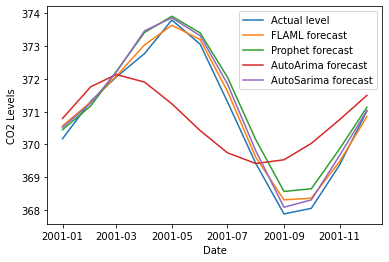

In [43]:
import matplotlib.pyplot as plt

plt.plot(X_test, y_test, label='Actual level')
plt.plot(X_test, flaml_y_pred, label='FLAML forecast')
plt.plot(X_test, prophet_y_pred, label='Prophet forecast')
plt.plot(X_test, autoarima_y_pred, label='AutoArima forecast')
plt.plot(X_test, autosarima_y_pred, label='AutoSarima forecast')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()